<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Practice Data Format Transformations: "Long" vs. "Wide" Format

<br>
---

In this lab, you will practice going between long and wide formats in `pandas`, dive deeper into `.melt()` and `.pivot_tables()`, and explore the pitfalls of hierarchical indices that we covered in the lesson.


Recall that **long format data** is structured so that:

- There are potentially multiple `ID` (identification) columns.
- There are pairs of columns such as `variable:value` that match a variable key to a value. (In the simplest case, there would be a single `variable` column and a single `value` column).
- The `variable` column corresponds to the multiple variable columns in a wide format data set. Instead of a column for each variable, you have a row for each `variable:value` pair *per ID*. 
- This is a standard format for SQL databases because it makes it easier to join different tables together with keys.

And **wide format data** is structured so that: 

- There are multiple `ID` _and_ `value` columns. In other words, there is a column for every "variable" with its own unique values.
- The format has the conceptual simplicity of a single column of values per variable, as well as a more compact matrix.
- It is not as useful for SQL-style operations: It can make it much harder or even impossible to join tables together on a value.
- It can be useful in `pandas` when you need to perform operations on variables **across columns**; for example, multiplying columns together to create a new column.
- It is the most commonly used format for data modeling (with some exceptions). I'll explain why when we get into the subject next week.

---

## A: The Humor Styles Data Set

We are going to explore a data set in which people answered a questionnaire about their "humor styles." The study tries to get at the differences in people's senses of humor as well as their relationships with humor.

---

### A.1: 32 Questions

Subjects reacted to **32** different statements, outlined here:

1. I usually don't laugh or joke with other people.
2. If I feel depressed, I can cheer myself up with humor.
3. If someone makes a mistake, I will tease them about it.
4. I let people laugh at me or make fun of me at my expense more than I should.
5. I don't have to work very hard to make other people laugh. I am a naturally humorous person.
6. Even when I'm alone, I am often amused by the absurdities of life.
7. People are never offended or hurt by my sense of humor.
8. I will often get carried away in putting myself down if it makes family or friends laugh.
9. I rarely make other people laugh by telling funny stories about myself.
10. If I am feeling upset or unhappy, I usually try to think of something funny about the situation to make myself feel better.
11. When telling jokes or saying funny things, I am usually not concerned about how other people are taking it.
12. I often try to make people like or accept me more by saying something funny about my own weaknesses, blunders, or faults.
13. I laugh and joke a lot with my closest friends.
14. My humorous outlook on life keeps me from getting overly upset or depressed about things.
15. I do not like it when people use humor as a way of criticizing or putting someone down.
16. I don't often say funny things to put myself down.
17. I usually don't like to tell jokes or amuse people.
18. If I'm by myself and I'm feeling unhappy, I make an effort to think of something funny to cheer myself up.
19. Sometimes I think of something that is so funny that I can't stop myself from saying it, even if it is not appropriate for the situation.
20. I often go overboard in putting myself down when I am making jokes or trying to be funny.
21. I enjoy making people laugh.
22. If I am feeling sad or upset, I usually lose my sense of humor.
23. I never participate in laughing at others even if all my friends are doing it.
24. When I am with friends or family, I often seem to be the one that other people make fun of or joke about.
25. I don't often joke around with my friends.
26. It is my experience that thinking about some amusing aspect of a situation is often a very effective way of coping with problems.
27. If I don't like someone, I often use humor or teasing to put them down.
28. If I am having problems or feeling unhappy, I often cover it up by joking around so that even my closest friends don't know how I really feel.
29. I usually can't think of witty things to say when I'm with other people.
30. I don't need to be with other people to feel amused. I can usually find things to laugh about even when I'm by myself.
31. Even if something is really funny to me, I will not laugh or joke about it if someone will be offended.
32. Letting others laugh at me is my way of keeping my friends and family in good spirits.

---

### A.2: Response Codes

For each question, there were five possible response codes (a "Likert scale") that corresponded to different answers. There was also a code to indicate no response by that subject.

    1 == "Never or very rarely true"
    2 == "Rarely true"
    3 == "Sometimes true"
    4 == "Often true"
    5 == "Very often or always true
    [-1 == Did not select an answer]

---

You can find more information about the questionnaire [here](https://en.wikipedia.org/wiki/Humor_styles).

---

## B: Load the Modules

Let's load the standard modules we always use. None of these are new to you.

---

In [1]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure charts appear in the notebook:
%matplotlib inline

---

## C: Load and Examine the Data

The data set is stored in your **```datasets```** directory.

The data set is called **```hsq_data.csv```**. `hsq`, as you might expect, stands for "Humor Styles Questionnaire."

[There is also a file called **```hsq_codebook.txt```**, which is a text file containing the information I detailed above. You can examine it if you'd like.]

---

### C.1: Create a path string and load it into `pandas`.

In [2]:
hsq_path = './datasets/hsq_data.csv'

hsq = pd.read_csv(hsq_path)

---

### C.2 Look at the header.

Let's make sure it looks like what we expect and that the data didn't load incorrectly. This, of course, is always good practice.

In [3]:
hsq.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q30,Q31,Q32,affiliative,selfenhancing,agressive,selfdefeating,age,gender,accuracy
0,2,2,3,1,4,5,4,3,4,3,...,4,2,2,4.0,3.5,3.0,2.3,25,2,100
1,2,3,2,2,4,4,4,3,4,3,...,4,3,1,3.3,3.5,3.3,2.4,44,2,90
2,3,4,3,3,4,4,3,1,2,4,...,5,4,2,3.9,3.9,3.1,2.3,50,1,75
3,3,3,3,4,3,5,4,3,-1,4,...,5,3,3,3.6,4.0,2.9,3.3,30,2,85
4,1,4,2,2,3,5,4,1,4,4,...,5,4,2,4.1,4.1,2.9,2.0,52,1,80


Looking at the header, it's apparent we have **32 columns for each question**. But, if we scroll over to the right, we can see that there are **seven columns of subject properties**.

What are these properties? Some are clear and some are not.

#### Styles of Humor:

1. **Affiliative**
    - The style of humor used to enhance one's relationships with others in a positive and benevolent way. 
2. **Self-enhancing** 
    - The style of humor related to having a good-natured attitude toward life and the ability to laugh at yourself, your circumstances, and the idiosyncrasies of life in a constructive, non-detrimental manner.
3. **Aggressive** 
    - The style of humor that is potentially detrimental toward others. This type of humor is characterized by the use of sarcasm, put-downs, teasing, criticism, ridicule, and other types of humor at the expense of others.   
4. **Self-defeating** 
    - The style of humor is characterized by the use of potentially detrimental humor toward one's self in order to gain approval from others. Individuals with high scores in this dimension engage in self-disparaging humor in which laughter is often at their own expense.
    
These dimensions of humor were calculated from the questionnaire responses. 

- The two positive dimensions of humor are: **affiliative** and **self-enhancing**. 
- The two _(purportedly)_ negative dimensions of humor are: **aggressive** and **self-defeating**.

We'll calculate these manually later to practice column-wise operations in `pandas`.

---

#### Demographics and Self-Reported Accuracy

The demographic columns are:

- **`age`**
- **`gender`**
    - 1 == male
    - 2 == female
    - 3 == other

It's useful to have demographics for each subject in a data set. We'll explore the reasons for this later when we start doing regressions and classifications.

The **accuracy** column is the self-reported accuracy of the responses by the subjects themselves — i.e., how accurate they thought their answers were on a scale from 0 to 100.

**If a subject entered 0 for accuracy, this actually means they didn't want to be included in the research.**

---

### C.3: Data shape

Let's start looking at our data. Print out the shape of the DataFrame.

In [4]:
# A:
hsq.shape

(1071, 39)

---

### C.4: Describe the data

**C.4.1** Print out the names of the columns. You can see that aggressive is misspelled as "agressive." Replace the name of that column specifically using the built-in ```.rename()``` function.

In [5]:
# A:
hsq.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31',
       'Q32', 'affiliative', 'selfenhancing', 'agressive', 'selfdefeating',
       'age', 'gender', 'accuracy'],
      dtype='object')

In [6]:
hsq.rename(columns = {'agressive':'aggressive'}, inplace=True)

**C.4.2** Use the built-in `.describe()` function to look at the data.

In [8]:
# A:
hsq.describe().T

,count,mean,std,min,25%,50%,75%,max
Q1,1071.0,2.025210,1.075782,-1.0,1.0,2.0,3.0,5.0
Q2,1071.0,3.342670,1.112898,-1.0,3.0,3.0,4.0,5.0
Q3,1071.0,3.078431,1.167877,-1.0,2.0,3.0,4.0,5.0
Q4,1071.0,2.833800,1.160252,-1.0,2.0,3.0,4.0,5.0
Q5,1071.0,3.599440,1.061281,-1.0,3.0,4.0,4.0,5.0
Q6,1071.0,4.152194,0.979315,-1.0,4.0,4.0,5.0,5.0
Q7,1071.0,3.277311,1.099974,-1.0,3.0,3.0,4.0,5.0
Q8,1071.0,2.535014,1.231380,-1.0,2.0,2.0,3.0,5.0
Q9,1071.0,2.582633,1.224530,-1.0,2.0,2.0,3.0,5.0
Q10,1071.0,2.869281,1.205013,-1.0,2.0,3.0,4.0,5.0


**C.4.3** The maximum age is 44,849, which is obviously impossible. Clearly, there was at least one subject who entered their age incorrectly.

**C.4.4** Calculate and print just the standard deviation for the columns.

In [9]:
# A:
hsq.std()

Q1                  1.075782
Q2                  1.112898
Q3                  1.167877
Q4                  1.160252
Q5                  1.061281
Q6                  0.979315
Q7                  1.099974
Q8                  1.231380
Q9                  1.224530
Q10                 1.205013
Q11                 1.249987
Q12                 1.229589
Q13                 0.884965
Q14                 1.270499
Q15                 1.378185
Q16                 1.214519
Q17                 1.147638
Q18                 1.206461
Q19                 1.258762
Q20                 1.123365
Q21                 0.968822
Q22                 1.241625
Q23                 1.221576
Q24                 1.148647
Q25                 0.885887
Q26                 1.206496
Q27                 1.291101
Q28                 1.318739
Q29                 1.210356
Q30                 1.135189
Q31                 1.309601
Q32                 1.233889
affiliative         0.708479
selfenhancing       0.661533
aggressive    

**C.4.5** There are three examples of potentially bad data in this data set:

1. The questions have different standard deviations, but we know that the range for each is restricted. This means that, for the questions with **higher standard deviations**, there is **more variability in the responses**. 
2. The standard deviation for age is 1,371, which is higher than any possible age range. This is an example of how outliers affect a lot of statistical measures.
3. The standard deviation is lower for the humor style columns. On average, people's values for these attributes are closer together. (Keep in mind, however, that this might just be because the range is "shrunk." This is why it is important to look at both and plot. There are also `-1`s in the responses that can skew the answers' distributions, as we will see below).

**C.4.6** Using `seaborn`, plot the distribution for `Q15` and the distribution for `aggressive` in two separate plots

[**Note:** You can set ```sns.set(rc={"figure.figsize": (12, 12)})```. Entering this before the distribution plot will set the figure size to 12x12, similar to using the `fig = plt.figure(figsize=(12,12))` pattern. This is just another way to accomplish the same thing, so use whichever you prefer.]


<Axes: xlabel='Q15', ylabel='Count'>

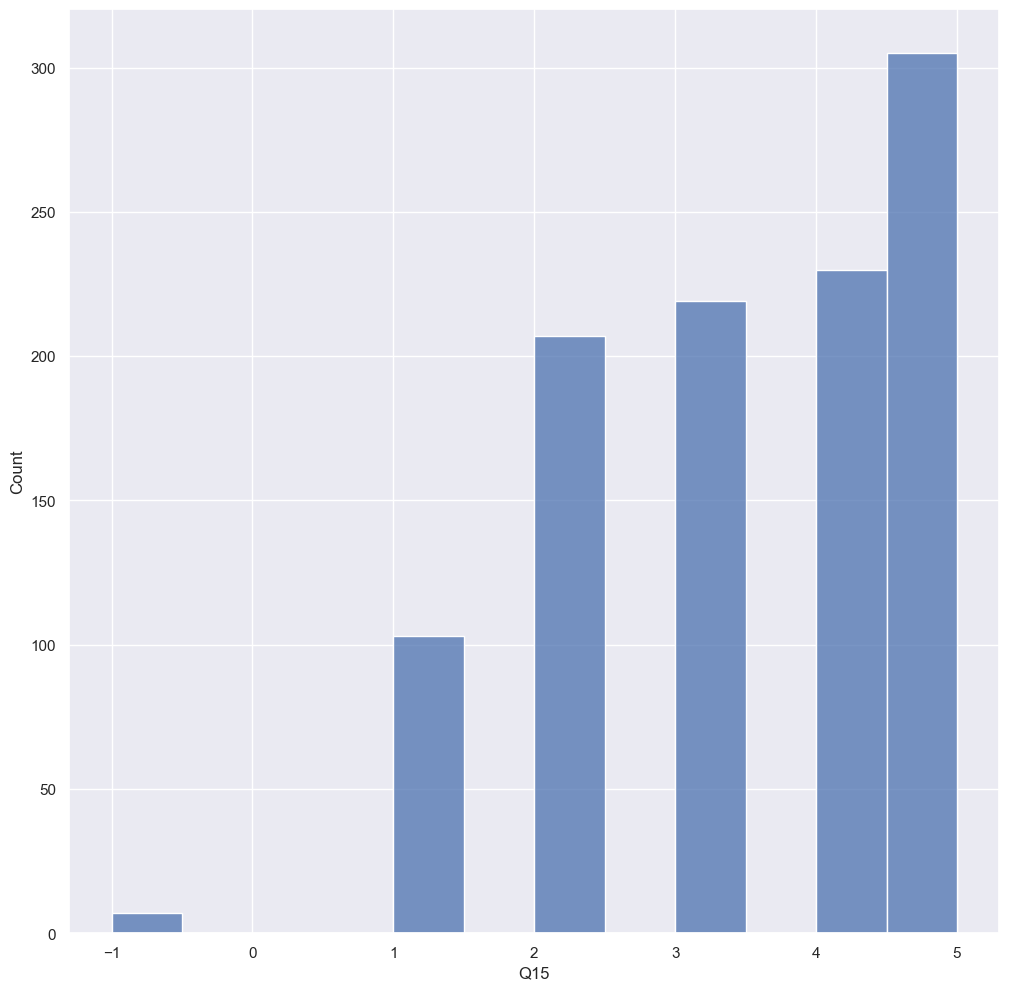

In [10]:
# A:
sns.set(rc={"figure.figsize": (12, 12)})
sns.histplot(data=hsq, x ='Q15')

<Axes: xlabel='aggressive', ylabel='Count'>

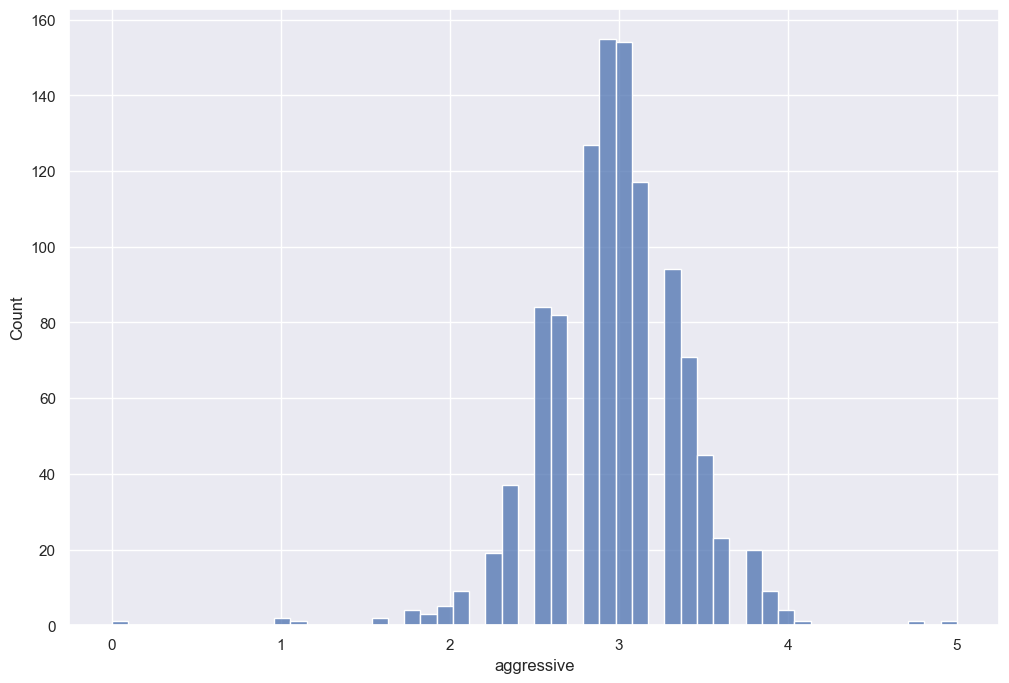

In [11]:
# A:
sns.set(rc={"figure.figsize": (12, 8)})
sns.histplot(data=hsq, x ='aggressive')

**C.4.7** Based on the plot's "tighter" distribution, it appears that the calculation of the `aggressive` style lowers the variability. Then again, the question distribution is far from normal, so the standard deviation measure is not that descriptive.

---

## D: Convert the Data From Wide to Long Format

### D.1: Make the question columns clearer.

**D.1.1** Before we transform our DataFrame to long format, we should make the questions more descriptive so we know what they're referencing. Use the provided dictionary of question numbers and names to transform the column labels.

In [12]:
column_change = {
    'Q1':'usually_dont_laugh',
    'Q2':'if_depressed_use_humor',
    'Q3':'tease_others_mistakes',
    'Q4':'let_others_laugh_at_me',
    'Q5':'make_others_laugh_easy',
    'Q6':'when_alone_amused',
    'Q7':'my_humor_never_offensive',
    'Q8':'use_self_deprecation',
    'Q9':'rarely_make_laugh_stories',
    'Q10':'if_upset_use_humor',
    'Q11':'dont_care_impact_jokes',
    'Q12':'self_deprecate_to_befriend',
    'Q13':'laugh_alot_with_friends',
    'Q14':'humorous_outlook_improves_mood',
    'Q15':'dislike_mean_humor',
    'Q16':'dont_self_deprecate',
    'Q17':'dont_like_telling_jokes',
    'Q18':'when_alone_try_laugh',
    'Q19':'joke_when_inappropriate',
    'Q20':'harshly_self_deprecate',
    'Q21':'enjoy_making_others_laugh',
    'Q22':'if_sad_cant_laugh',
    'Q23':'never_use_mean_humor',
    'Q24':'friends_often_tease_me',
    'Q25':'dont_often_joke',
    'Q26':'humor_coping_mechanism',
    'Q27':'tease_disliked_people',
    'Q28':'hide_unhappiness_humor',
    'Q29':'cant_think_witty_things',
    'Q30':'dont_need_others_amused',
    'Q31':'if_mean_wont_laugh',
    'Q32':'allow_others_tease_me'
}

In [13]:
# A:
hsq.rename(columns = column_change , inplace=True)

**D.1.2** Print out the columns and check the header to make sure they were renamed.

In [14]:
# A:
hsq.head()

,usually_dont_laugh,if_depressed_use_humor,tease_others_mistakes,let_others_laugh_at_me,make_others_laugh_easy,when_alone_amused,my_humor_never_offensive,use_self_deprecation,rarely_make_laugh_stories,if_upset_use_humor,...,dont_need_others_amused,if_mean_wont_laugh,allow_others_tease_me,affiliative,selfenhancing,aggressive,selfdefeating,age,gender,accuracy
0,2,2,3,1,4,5,4,3,4,3,...,4,2,2,4.0,3.5,3.0,2.3,25,2,100
1,2,3,2,2,4,4,4,3,4,3,...,4,3,1,3.3,3.5,3.3,2.4,44,2,90
2,3,4,3,3,4,4,3,1,2,4,...,5,4,2,3.9,3.9,3.1,2.3,50,1,75
3,3,3,3,4,3,5,4,3,-1,4,...,5,3,3,3.6,4.0,2.9,3.3,30,2,85
4,1,4,2,2,3,5,4,1,4,4,...,5,4,2,4.1,4.1,2.9,2.0,52,1,80


---

### D.2: Add a `subject_id` column.

We have an index that identifies the rows, but we'll want a column that contains the ID for each subject so we can keep track of which rows correspond with which subject.

If this is not clear, don't worry. The reason we are doing this will become clear once we visualize the long form data.

**D.2.1** Create an ID array containing the length of our data's rows in which each element is unique. You can use the numpy `arange()` method to create an array.

[**Note:** Don't call this variable "ID," as this is reserved. In Jupyter Notebook, green font indicates a reserved name. If a variable you're typing turns green, you should revise it.]

In [15]:
# A:
import numpy as np

subject_id = np.arange(1071)

**D.2.2** Add a new column to your data set that contains the values of the subject IDs array. Call it `subject_id`.

In [16]:
hsq['subject_id']=subject_id

In [17]:
hsq.head()

,usually_dont_laugh,if_depressed_use_humor,tease_others_mistakes,let_others_laugh_at_me,make_others_laugh_easy,when_alone_amused,my_humor_never_offensive,use_self_deprecation,rarely_make_laugh_stories,if_upset_use_humor,...,if_mean_wont_laugh,allow_others_tease_me,affiliative,selfenhancing,aggressive,selfdefeating,age,gender,accuracy,subject_id
0,2,2,3,1,4,5,4,3,4,3,...,2,2,4.0,3.5,3.0,2.3,25,2,100,0
1,2,3,2,2,4,4,4,3,4,3,...,3,1,3.3,3.5,3.3,2.4,44,2,90,1
2,3,4,3,3,4,4,3,1,2,4,...,4,2,3.9,3.9,3.1,2.3,50,1,75,2
3,3,3,3,4,3,5,4,3,-1,4,...,3,3,3.6,4.0,2.9,3.3,30,2,85,3
4,1,4,2,2,3,5,4,1,4,4,...,4,2,4.1,4.1,2.9,2.0,52,1,80,4


---

### D.3: Transform the data to long format.

We're now going to transform our data set from **wide** to **long** format.

The `pandas` function to convert a wide data set to a long data set is **```pd.melt()```**.

Here is an example of the function call for a fictional data set:

```python
id_theft_long = pd.melt(id_theft_wide,
                        id_vars=['full_name','birth_date'],
                        value_vars=['ccv','zip_code','credit_card_number','pin','ssn'],
                        var_name='personal_info',
                        value_name='info_value')
```

So, what are the inputs for this function?

- **```id_theft_wide```:** This is my wide format data set with people's personal info.
- **```id_vars```:** These are the columns that are _already identifiers_ or can otherwise not be included in `value_vars` because they are a different data type.
- **```value_vars```:** These are the columns that will now be represented in a single value column.
- **```var_name```:** This is the name of the new, single column that will contain the identifiers for each value by row. The `value_var` columns are now represented in a single column.
- **```value_name```:** This is the name of the new single column that contains the values from the `value_vars` columns.

**D.3.1** Convert your data set to long format, assigned it to a new DataFrame.

- Your `id_vars` will be:
    - Subject id
    - Age
    - Gender
- Your ```value_vars``` will be the names of your question, accuracy, and four humor style columns. (the  `to_value_variable_columns` variable that is created below)
- Make ```var_name``` "variable."
- Make ```value_name``` "value."


In [18]:
# set up of the value_vars
style_columns = ['affiliative','selfenhancing','aggressive','selfdefeating']
question_columns = list(column_change.values())
to_value_variable_columns = style_columns + question_columns + ['accuracy']

# A: perform the melt
hsq_long = pd.melt(hsq, id_vars=['subject_id', 'age', 'gender'], 
                   value_vars = to_value_variable_columns,
                  var_name= 'variable', value_name ='value')

hsq_long

,subject_id,age,gender,variable,value
0,0,25,2,affiliative,4.0
1,1,44,2,affiliative,3.3
2,2,50,1,affiliative,3.9
3,3,30,2,affiliative,3.6
4,4,52,1,affiliative,4.1
...,...,...,...,...,...
39622,1066,18,2,accuracy,95.0
39623,1067,31,1,accuracy,95.0
39624,1068,15,1,accuracy,95.0
39625,1069,21,2,accuracy,87.0


**D.3.2** Look at the header. Print the shape of the long DataFrame, as well as the unique values in the `variable` column.

In [19]:
# A:
print(hsq_long.shape)
print(hsq_long['variable'].unique())

(39627, 5)
['affiliative' 'selfenhancing' 'aggressive' 'selfdefeating'
 'usually_dont_laugh' 'if_depressed_use_humor' 'tease_others_mistakes'
 'let_others_laugh_at_me' 'make_others_laugh_easy' 'when_alone_amused'
 'my_humor_never_offensive' 'use_self_deprecation'
 'rarely_make_laugh_stories' 'if_upset_use_humor' 'dont_care_impact_jokes'
 'self_deprecate_to_befriend' 'laugh_alot_with_friends'
 'humorous_outlook_improves_mood' 'dislike_mean_humor'
 'dont_self_deprecate' 'dont_like_telling_jokes' 'when_alone_try_laugh'
 'joke_when_inappropriate' 'harshly_self_deprecate'
 'enjoy_making_others_laugh' 'if_sad_cant_laugh' 'never_use_mean_humor'
 'friends_often_tease_me' 'dont_often_joke' 'humor_coping_mechanism'
 'tease_disliked_people' 'hide_unhappiness_humor'
 'cant_think_witty_things' 'dont_need_others_amused' 'if_mean_wont_laugh'
 'allow_others_tease_me' 'accuracy']


In [20]:
# A:

print(hsq_long['variable'].nunique())

37


**D.3.3** Print the entire subset of the DataFrame where ```subject_id == 10```.

In [21]:
# A:
hsq_long[hsq_long['subject_id'] == 10]

,subject_id,age,gender,variable,value
10,10,33,1,affiliative,4.5
1081,10,33,1,selfenhancing,4.5
2152,10,33,1,aggressive,3.4
3223,10,33,1,selfdefeating,2.6
4294,10,33,1,usually_dont_laugh,1.0
5365,10,33,1,if_depressed_use_humor,5.0
6436,10,33,1,tease_others_mistakes,1.0
7507,10,33,1,let_others_laugh_at_me,3.0
8578,10,33,1,make_others_laugh_easy,4.0
9649,10,33,1,when_alone_amused,5.0


**D.3.4** Why would the row index for the subset be increasing but there still be such a big difference between them for subject 10?

The ```.melt()``` function is not putting the long DataFrame in order of subject ID. Instead, it is ordering the DataFrame by one of the other variables first. Because of that, the different rows that correspond to subject 10 are spread out across the DataFrame.

This is why it is important to add the `subject_id` column prior to converting to long format and use it as an ID column. Without it, we would not know which rows corresponded with which subjects after conversion.

**D.3.5** Figure out a way to order the index by `subject_id`. Google it if you need to. Reset the index of the sorted DataFrame, and drop the old index with `drop=True`.

In [22]:
# A:
hsq_long.sort_values('subject_id', inplace=True)
hsq_long.head()

,subject_id,age,gender,variable,value
0,0,25,2,affiliative,4.0
25704,0,25,2,enjoy_making_others_laugh,4.0
13923,0,25,2,if_upset_use_humor,3.0
18207,0,25,2,humorous_outlook_improves_mood,4.0
21420,0,25,2,dont_like_telling_jokes,2.0


In [23]:
hsq_long.loc[subject_id,]

,subject_id,age,gender,variable,value
0,0,25,2,affiliative,4.0
1,1,44,2,affiliative,3.3
2,2,50,1,affiliative,3.9
3,3,30,2,affiliative,3.6
4,4,52,1,affiliative,4.1
...,...,...,...,...,...
1066,1066,18,2,affiliative,2.5
1067,1067,31,1,affiliative,4.8
1068,1068,15,1,affiliative,4.4
1069,1069,21,2,affiliative,3.1


In [24]:
# A:
hsq_long.reset_index(drop =True, inplace= True)
hsq_long.head()

,subject_id,age,gender,variable,value
0,0,25,2,affiliative,4.0
1,0,25,2,enjoy_making_others_laugh,4.0
2,0,25,2,if_upset_use_humor,3.0
3,0,25,2,humorous_outlook_improves_mood,4.0
4,0,25,2,dont_like_telling_jokes,2.0


---

## E: Clean the Data Set and Transform the Variables

Transformation and manipulation of variables within data subsets is an essential data science skill!

Cleaning is also important. Cleaning data includes, but is not limited to, removing "bad" data or any data that should be excluded from your analyses, changing data types, fixing "bad" data, and restructuring data for analysis.

### E.1: Convert the `gender` column to a string representation.

Recall that:
    
    1 == 'male'
    2 == 'female'
    3 == 'other'

Let's make the `gender` column more readable. Convert this numeric column to a string column that contains the `gender` labels by first defining a function.

In [28]:
# A: Define function for converting gender to string
def gender_description (gender):
    if gender==1:
        return 'male'
    elif gender==2:
        return 'female'
    else:
        return 'other'
# def convert_gender(gender_val):


In [29]:
# Apply the function
hsq_long['gender']=hsq_long['gender'].apply(gender_description)

In [30]:
hsq_long.head()

,subject_id,age,gender,variable,value
0,0,25,female,affiliative,4.0
1,0,25,female,enjoy_making_others_laugh,4.0
2,0,25,female,if_upset_use_humor,3.0
3,0,25,female,humorous_outlook_improves_mood,4.0
4,0,25,female,dont_like_telling_jokes,2.0


---

### E.2: Removing subjects from the data set.

**E.2.1** Users who did not respond to certain questions will have potentially unreasonable values for their humor style ratings. 

Find the users who responded ```-1``` on **any** of the questions. 
(You can try to obtain a list of the unique `subject_id`)

In [31]:
# A:
bad_users = hsq_long[hsq_long['value']==-1]

In [32]:
bad_users

,subject_id,age,gender,variable,value
147,3,30,female,rarely_make_laugh_stories,-1.0
449,12,29,female,dont_often_joke,-1.0
960,25,16,female,my_humor_never_offensive,-1.0
1685,45,16,male,dislike_mean_humor,-1.0
1686,45,16,male,if_depressed_use_humor,-1.0
...,...,...,...,...,...
37961,1025,34,male,my_humor_never_offensive,-1.0
38375,1037,25,male,enjoy_making_others_laugh,-1.0
38607,1043,15,female,humor_coping_mechanism,-1.0
38741,1047,25,male,dont_like_telling_jokes,-1.0


**E.2.2** Remove all rows from the data sets that correspond to the bad users.

HINTS:
    
- The **```~```** operator can invert a logical condition/Boolean array.
- The built-in **```.isin()```** function takes a list of values and returns a Boolean array that indicates if any of the Series or DataFrame values were members of the list.
    

In [33]:
# A: suppose you have found the bad users
hsq_long[~hsq_long['subject_id'].isin(bad_users)]

,subject_id,age,gender,variable,value
0,0,25,female,affiliative,4.0
1,0,25,female,enjoy_making_others_laugh,4.0
2,0,25,female,if_upset_use_humor,3.0
3,0,25,female,humorous_outlook_improves_mood,4.0
4,0,25,female,dont_like_telling_jokes,2.0
...,...,...,...,...,...
39622,1070,30,female,friends_often_tease_me,2.0
39623,1070,30,female,humor_coping_mechanism,4.0
39624,1070,30,female,tease_others_mistakes,1.0
39625,1070,30,female,enjoy_making_others_laugh,5.0


**E.2.3** Subjects who entered 0 for accuracy didn't want to be part of the research. Respecting their wishes, check if any entered 0 for accuracy and remove them.

In [37]:
# A:
removed_users= hsq_long[((hsq_long['variable']=='accuracy') & (hsq_long['value']==0))]

hsq_long = hsq_long[~hsq_long.subject_id.isin(removed_users)]

**E.2.4** Find the subjects who reported an age older than 100 and remove them, because they're lying. 
  
_While some people can live to be 100 years old, nobody who makes it that far knows how to take an online survey._

In [38]:
# A:
liar=hsq_long[hsq_long['age']>100]
liars= liar['subject_id'].unique()
liars

array([293, 303, 632, 957])

---

### E.3: Transform the variables, inverting some.

Some of the scales need to be reversed. Next, we'll transform variables so that the valence of the 1-5 Likert scale always goes from negative to positive.

For example, the scale for this question is already correctly rated from 1 to 5:

    Even if I'm by myself, I'm often amused by the absurdity of life.
    
This one, on the other hand, needs to be reversed, as the `1` value actually corresponds to a positive humor style:

    I usually don't laugh or joke around much with other people.
    
The following is a list questions that need to be inverted.

In [39]:
inverted_questions = ['usually_dont_laugh',
                      'tease_others_mistakes',
                      'let_others_laugh_at_me',
                      'rarely_make_laugh_stories',
                      'use_self_deprecation',
                      'tease_disliked_people',
                      'cant_think_witty_things',
                      'allow_others_tease_me',
                      'harshly_self_deprecate',
                      'dont_often_joke',
                      'if_sad_cant_laugh',
                      'dont_like_telling_jokes',
                      'dont_care_impact_jokes',
                      'self_deprecate_to_befriend',
                      'friends_often_tease_me',
                      'joke_when_inappropriate']

**E.3.1** Write a function that will accept a score value and "invert" the score — that is to say:

    1 -> 5
    2 -> 4
    3 -> 3
    4 -> 2
    5 -> 1

In [40]:
# A:
def inverted_score(score):
    return 6 - score

In [42]:
inverted_score(4)

2

**E.3.2** Apply the score inverter function to the values where the variable is included in the ```inverted_question``` list, reassigning the ```value``` column at those locations.

Don't forget about the ```.isin()``` function for Series, as well as the ```.map()``` or ```.apply()``` functions for element-related Series operations!

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.isin.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html

http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.Series.apply.html

**Hint:** You'll have to use `.loc` to subset the specific rows and columns to be changed.

In [44]:
# A:
hsq_long.loc[hsq_long['variable'].isin(inverted_questions),'value']=hsq_long[hsq_long['variable'].isin(inverted_questions)]['value'].apply(inverted_score)

---

## F: Transforming the Data Set Back to Wide Format

Now we will transform the long format DataFrame back to wide format to analyse the responses by gender and age.

We are going to be using the powerful **```pd.pivot_table()```** function. 

---

### F.1: Use `pd.pivot_table()` to re-widen your data.

The ```pd.pivot_table()``` function takes a variety of arguments. For now, let's just set the keyword arguments and corresponding values outlined below:

- **`data`**: The first argument is the DataFrame you want to pivot.

- **`index`**: The key(s) to group by along the pivot table indices, or rows. These "keys" are column names in your DataFrame.

```python
index = ['gender','age']
```

- **`columns`**: The key(s) to group by along the pivot table columns. These are also names or column names.

```python
columns = ['variable']
```

- **`values`**: The key(s) that are the values to "aggregate." We'll cover more on aggregation soon, so don't worry about it for now.

```python
values = 'value'
```

- **`aggfunc`**: This should be the count, which can be the function `len`.

```python
aggfunc = len
```

**F.1.1** Create a new widened DataFrame from your long data set using the specified keyword arguments above. Print out the head and shape.

In [45]:
# A:
hsq_wide = hsq_long.pivot_table(index=['gender','age'], columns='variable', values='value', aggfunc=len)

#### F.1.2 Reset the index and turn the data into long format.

The long form melted data set should have four columns: `gender`,`age`, `variable`, and `count`.

In [46]:
# A:
hsq_wide = hsq_wide.reset_index()
hsq_wide

variable,gender,age,accuracy,affiliative,aggressive,allow_others_tease_me,cant_think_witty_things,dislike_mean_humor,dont_care_impact_jokes,dont_like_telling_jokes,...,rarely_make_laugh_stories,self_deprecate_to_befriend,selfdefeating,selfenhancing,tease_disliked_people,tease_others_mistakes,use_self_deprecation,usually_dont_laugh,when_alone_amused,when_alone_try_laugh
0,female,14,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
1,female,15,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
2,female,16,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
3,female,17,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
4,female,18,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,other,27,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
111,other,30,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
112,other,38,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
113,other,39,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [48]:
hsq_count_long = hsq_wide.melt(id_vars=['gender','age'],value_name='count')
hsq_count_long.head()

,gender,age,variable,count
0,female,14,accuracy,11
1,female,15,accuracy,21
2,female,16,accuracy,34
3,female,17,accuracy,32
4,female,18,accuracy,36


#### F.1.3 Merge the `count` long data set into the full long data set.

Merge these small counts by `gender`,`age` and `variable` with the original long DataFrame.

The `count` DataFrame contains three key variables we need to match in the full long DataFrame.

Your code would look something like this:

```python
hsq_long_merged = hsq_long.merge(hsq_count_long, on=['gender','age','variable'])
```

In [52]:
merged = pd.merge(hsq_long, hsq_count_long, how='left', on=['gender','age','variable'])
merged

,subject_id,age,gender,variable,value,count
0,0,25,female,affiliative,4.0,15
1,0,25,female,enjoy_making_others_laugh,4.0,15
2,0,25,female,if_upset_use_humor,3.0,15
3,0,25,female,humorous_outlook_improves_mood,4.0,15
4,0,25,female,dont_like_telling_jokes,4.0,15
...,...,...,...,...,...,...
39622,1070,30,female,friends_often_tease_me,4.0,11
39623,1070,30,female,humor_coping_mechanism,4.0,11
39624,1070,30,female,tease_others_mistakes,5.0,11
39625,1070,30,female,enjoy_making_others_laugh,5.0,11


#### F.1.4 Use the `.pivot_table()` function to calculate the mean of both the original values and the counts by `gender` and `age` across variables.

The code could be something like this:

```python
value_count_means = pd.pivot_table(hsq_long_merged,
                                   index=['gender','age'],
                                   columns=['variable'],
                                   values=['value', 'count'],
                                   aggfunc=np.mean)
```

In [54]:
# A:
value_count_means = merged.pivot_table(index=['gender','age'], columns='variable', values=['value','count'], aggfunc = np.mean)

In [55]:
value_count_means.head()

count                                               \
variable   accuracy affiliative aggressive allow_others_tease_me   
gender age                                                         
female 14        11          11         11                    11   
       15        21          21         21                    21   
       16        34          34         34                    34   
       17        32          32         32                    32   
       18        36          36         36                    36   

                                                                              \
variable   cant_think_witty_things dislike_mean_humor dont_care_impact_jokes   
gender age                                                                     
female 14                       11                 11                     11   
       15                       21                 21                     21   
       16                       34                 34                     34   
       17                       32                 32                     32   
       18                       36                 36                     36   

                                                                            \
variable   dont_like_telling_jokes dont_need_others_amused dont_often_joke   
gender age                                                                   
female 14                       11                      11              11   
       15                       21                      21              21   
       16                       34                      34              34   
       17                       32                      32              32   
       18                       36                      36              36   

            ...                     value                             \
variable    ... rarely_make_laugh_stories self_deprecate_to_befriend   
gender age  ...                                                        
female 14   ...                  3.181818                   3.090909   
       15   ...                  3.476190                   3.571429   
       16   ...                  3.500000                   3.323529   
       17   ...                  3.468750                   2.843750   
       18   ...                  3.277778                   3.277778   

                                                              \
variable   selfdefeating selfenhancing tease_disliked_people   
gender age                                                     
female 14       2.509091      3.509091              3.909091   
       15       2.695238      3.347619              2.952381   
       16       2.752941      3.400000              3.970588   
       17       2.890625      3.231250              3.968750   
       18       2.838889      3.427778              3.333333   

                                                                          \
variable   tease_others_mistakes use_self_deprecation usually_dont_laugh   
gender age                                                                 
female 14               2.454545             4.181818           4.272727   
       15               2.428571             3.523810           3.904762   
       16               2.941176             3.647059           3.970588   
       17               3.000000             3.562500           4.000000   
       18               2.861111             3.611111           3.888889   

                                                   
variable   when_alone_amused when_alone_try_laugh  
gender age                                         
female 14           4.454545             3.181818  
       15           4.238095             2.761905  
       16           4.117647             2.882353  
       17           4.187500             2.125000  
       18           4.111111             2.888889  

[5 rows x 74 columns]

---

### F.4 Flattening a MultiIndex DataFrame

The MultiIndex is a powerful tool, but let's go back to standard indexed data.

You can use **```.reset_index()```** or **`.to_records()`** to reach the same eventual result.

Try it out on the wide data below using the following:

```python
value_count_means.reset_index()
pd.DataFrame(value_count_means.to_records())
```

In [56]:
# A:
flat = value_count_means.reset_index()

In [57]:
# A:
pd.DataFrame(value_count_means.to_records())

,gender,age,"('count', 'accuracy')","('count', 'affiliative')","('count', 'aggressive')","('count', 'allow_others_tease_me')","('count', 'cant_think_witty_things')","('count', 'dislike_mean_humor')","('count', 'dont_care_impact_jokes')","('count', 'dont_like_telling_jokes')",...,"('value', 'rarely_make_laugh_stories')","('value', 'self_deprecate_to_befriend')","('value', 'selfdefeating')","('value', 'selfenhancing')","('value', 'tease_disliked_people')","('value', 'tease_others_mistakes')","('value', 'use_self_deprecation')","('value', 'usually_dont_laugh')","('value', 'when_alone_amused')","('value', 'when_alone_try_laugh')"
0,female,14,11,11,11,11,11,11,11,11,...,3.181818,3.090909,2.509091,3.509091,3.909091,2.454545,4.181818,4.272727,4.454545,3.181818
1,female,15,21,21,21,21,21,21,21,21,...,3.476190,3.571429,2.695238,3.347619,2.952381,2.428571,3.523810,3.904762,4.238095,2.761905
2,female,16,34,34,34,34,34,34,34,34,...,3.500000,3.323529,2.752941,3.400000,3.970588,2.941176,3.647059,3.970588,4.117647,2.882353
3,female,17,32,32,32,32,32,32,32,32,...,3.468750,2.843750,2.890625,3.231250,3.968750,3.000000,3.562500,4.000000,4.187500,2.125000
4,female,18,36,36,36,36,36,36,36,36,...,3.277778,3.277778,2.838889,3.427778,3.333333,2.861111,3.611111,3.888889,4.111111,2.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,other,27,2,2,2,2,2,2,2,2,...,4.500000,3.000000,2.300000,4.000000,3.500000,3.500000,3.500000,4.500000,4.500000,4.000000
111,other,30,1,1,1,1,1,1,1,1,...,2.000000,5.000000,1.600000,2.300000,5.000000,4.000000,5.000000,2.000000,5.000000,1.000000
112,other,38,1,1,1,1,1,1,1,1,...,3.000000,2.000000,3.500000,4.300000,5.000000,4.000000,3.000000,5.000000,5.000000,4.000000
113,other,39,1,1,1,1,1,1,1,1,...,3.000000,4.000000,2.900000,4.500000,5.000000,2.000000,4.000000,4.000000,5.000000,5.000000


In the case of `.reset_index()`, your index is now called `variable.` With `.to_records()`, the index is simply the standard integer labels for rows. All the hierarchical indices have been flattened down into columns.

Check out the ```.columns```.

In [58]:
# A:
flat_v = pd.DataFrame(value_count_means.to_records())

In [59]:
flat_v.columns

Index(['gender', 'age', '('count', 'accuracy')', '('count', 'affiliative')',
       '('count', 'aggressive')', '('count', 'allow_others_tease_me')',
       '('count', 'cant_think_witty_things')',
       '('count', 'dislike_mean_humor')',
       '('count', 'dont_care_impact_jokes')',
       '('count', 'dont_like_telling_jokes')',
       '('count', 'dont_need_others_amused')', '('count', 'dont_often_joke')',
       '('count', 'dont_self_deprecate')',
       '('count', 'enjoy_making_others_laugh')',
       '('count', 'friends_often_tease_me')',
       '('count', 'harshly_self_deprecate')',
       '('count', 'hide_unhappiness_humor')',
       '('count', 'humor_coping_mechanism')',
       '('count', 'humorous_outlook_improves_mood')',
       '('count', 'if_depressed_use_humor')',
       '('count', 'if_mean_wont_laugh')', '('count', 'if_sad_cant_laugh')',
       '('count', 'if_upset_use_humor')',
       '('count', 'joke_when_inappropriate')',
       '('count', 'laugh_alot_with_friends')',
  